In [1]:
from qutip import *
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
plt.rcParams["figure.figsize"] = (20,10)

In [2]:
# Constants
h = 6.602e-34
hbar = h/(2*np.pi)
kB = 1.38e-23
eps_0 = 8.85e-12
c_0 = 299792458
e = 1.602e-19
m_e = 9.109e-31
a_0 = 0.53e-10
norm = 1e9
mu_B = e*hbar/(2*m_e)

In [3]:
#Internal basis vectors expressed in lab frame. SiV high symmetry axis is along z: <111>
x = np.array([-1,1,0])
x = x/np.linalg.norm(x)
y = np.array([-1,-1,2])
y = y/np.linalg.norm(y)
z = np.array([1,1,1])
z = z/np.linalg.norm(z)

#Rotation matrix to switch from internal to external lab frame
R_ext_int = np.vstack((x,y,z)).T
R_int_ext = np.linalg.inv(R_ext_int)

In [4]:
''' 
    States and operators:
    Orbitals ordering
    0: |e_gx>
    1: |e_gy>
    2: |e_ux>
    3: |e_uy>

    Therefore orbital plus operator L_p_x = |e_g_y><e_g_x| ... 
    Due to D3d symmetry only L_z is non-zero. L_x and L_y vanish.

    Define spin up |🠕> as lower energy state.
'''
N_orbs = 4 
egx = basis(N_orbs, 0)
egy = basis(N_orbs, 1)
eux = basis(N_orbs, 2)
euy = basis(N_orbs, 3)

N_spins = 2
su = basis(N_spins,0)
sd = basis(N_spins,1)
N = N_orbs*N_spins

In [5]:
'''System Dynamics:
Orbital part comprising Spin-Orbit, Jahn Teller, Zeeman and Strain couplin
'''
HOrb = Qobj(np.zeros((N_orbs, N_orbs)))
HOrb += 1.68*e/h*(eux*eux.dag()+euy*euy.dag())
HOrb = tensor(HOrb, qeye(N_spins))

In [6]:
#Spin-Orbit coupling
SO_g = 46e9
SO_e = 250e9
HSO = -SO_g/2*tensor(1j*egy*egx.dag() - 1j*egx*egy.dag(), su*su.dag() - sd*sd.dag()) 
HSO+= -SO_e/2*tensor(1j*euy*eux.dag() - 1j*eux*euy.dag(), su*su.dag() - sd*sd.dag()) 

In [7]:
#Strain coupling
delta_g = 0
alpha_g = 0
beta_g = 0
HStr_g = (delta_g+alpha_g)*egx*egx.dag()
HStr_g += beta_g*egx*egy.dag()
HStr_g += beta_g*egy*egx.dag()
HStr_g += (delta_g-alpha_g)*egy*egy.dag()

delta_e = 0
alpha_e = 0
beta_e = 0
HStr_e = (delta_e+alpha_e)*eux*eux.dag()
HStr_e += beta_e*eux*euy.dag()
HStr_e += beta_e*euy*eux.dag()
HStr_e += (delta_e-alpha_e)*euy*euy.dag()

HStr = HStr_g + HStr_e
HStr = tensor(HStr, qeye(N_spins))

735.1344713321886
735.217402865481
735.5854117898166
735.6684451024894


In [49]:
HSys = HOrb+HSO
HSys = HSys/norm

energies, eigenstates = HSys.eigenstates()
transitions = []
nu_A = energies[7]-energies[1]
nu_B = energies[7]-energies[3]
nu_C = energies[5]-energies[1]
nu_D = energies[5]-energies[3]

# Dipole operators
dx =  eux*egx.dag() - euy*egy.dag()
dy = -euy*egx.dag() - eux*egy.dag()
dz =  2*(eux*egx.dag() + euy*egy.dag())

# Interaction (Laser) Hamiltonian is constructed within already performed rotating frame transformation and rotating wave approximation.
# In addition, Laser is assumed to be a coherent state and the corresponding photon bath is already traced out, leaving a pure color center Hamiltonian.
def rect_seq(start, width, num_pulses, delay, timeres):
    def rect(t, start, width):
        return np.heaviside(t-start,1)-np.heaviside(t-(start+width),1)

    def func(t, args=None):
        try:
            return seq[np.argmin(np.abs(t-t_seq))]
        except Exception as e:
            print(e)
            return 0

    if not timeres:
        timeres = width/100

    t_max = start + num_pulses*width+delay*np.sum(np.arange(1,num_pulses+1,1))
    t_seq = np.arange(0, t_max, timeres)
    seq = np.zeros_like(t_seq)
    for i in range(num_pulses):
        start = start + width*i + delay*np.sum(np.arange(1,i+1,1))
        seq += rect(t_seq, start, width)
    # plt.plot(t_seq, seq, alpha=0.7, linestyle='-.')
    return t_seq, func


# External (lab) and internal (SiV) polarization of electric laser field, Rabi frequency as well as bare frequency
Omega_L1 = 1*1e9/norm
nu_L1 = nu_C
eps_L1_ext = np.array([1,1,1])
eps_L1_ext = 1/np.linalg.norm(eps_L1_ext)*eps_L1_ext
eps_L1_int = np.squeeze(R_int_ext @ eps_L1_ext)
H_L1 = Omega_L1*tensor(eps_L1_int[0]*(dx + dx.dag()), qeye(N_spins))
H_L1 += Omega_L1*tensor(eps_L1_int[1]*(dy + dy.dag()), qeye(N_spins))
H_L1 += Omega_L1*tensor(eps_L1_int[2]*(dz + dz.dag()), qeye(N_spins))

Omega_L2 = 1*1e9/norm
nu_L2 = nu_D
eps_L2_ext = np.array([1,1,1])
eps_L2_ext = 1/np.linalg.norm(eps_L2_ext)*eps_L2_ext
eps_L2_int = np.squeeze(R_int_ext @ eps_L2_ext)
H_L2 = Omega_L2*tensor(eps_L2_int[0]*(dx + dx.dag()), qeye(N_spins))
H_L2 += Omega_L2*tensor(eps_L2_int[1]*(dy + dy.dag()), qeye(N_spins))
H_L2 += Omega_L2*tensor(eps_L2_int[2]*(dz + dz.dag()), qeye(N_spins))


# Performing a rotating frame transformation on the system Hamiltonian
# https://physics.stackexchange.com/questions/458654/rotating-wave-approximation-and-classical-rabi-oscillations-why-dont-the-fast
# https://physics.stackexchange.com/questions/222104/what-is-the-interaction-picture-or-rotating-frame-in-quantum-mechanics

pulse_t_res = 1e-2
if Omega_L1:
    start_L1 = 1
    width_L1 = 5
    num_pulses_L1 = 2
    delay_L1 = width_L1+3
    t_seq_L1, pulse_seq_L1 = rect_seq(start_L1, width_L1, num_pulses_L1, delay_L1, pulse_t_res)

    HSys -= nu_L1*tensor(eux*eux.dag()+euy*euy.dag(), qeye(N_spins))
    Hints = [[H_L1, pulse_seq_L1]]

if Omega_L2:
    start_L2 = 1+5+1
    width_L2 = 5
    num_pulses_L2 = 2
    delay_L2 = width_L2+3
    t_seq_L2, pulse_seq_L2 = rect_seq(start_L2, width_L2, num_pulses_L2, delay_L2, pulse_t_res)
    
    if Omega_L1:
        HSys += (nu_L2-nu_L1)*tensor(egy*egy.dag()+egy*egy.dag(), qeye(N_spins))
        Hints.append([H_L2, pulse_seq_L2])
    else:
        HSys -= nu_L2*tensor(eux*eux.dag()+euy*euy.dag(), qeye(N_spins))
        Hints = [[H_L2, pulse_seq_L2]]

H=[HSys]
for Hint in Hints:
    H.append(Hint)

In [56]:
# Environmental interactions
T = 5

n_th_pht = np.exp(-h*energies[4]/(kB*T))
n_th_phn_g = np.exp(-h*46e9/(kB*T))
n_th_phn_e = np.exp(-h*250e9/(kB*T))
# print("Mean phonon 46GHz occupation: ", n_th_phn_g)
# print("Mean phonon 250GHz occupation: ", n_th_phn_g)
# print("Mean photon occupation: ", n_th_pht)

tau_pht_A = 1.7e-9
tau_pht_B = 1.7e-9
tau_pht_C = 1.7e-9
tau_pht_D = 1.7e-9

tau_phn_e = 200e-12
tau_phn_g = 400e-12

c_ops = []
Gamma_C_up = 1/tau_pht_C*(n_th_pht)/norm
Gamma_C_down = 1/tau_pht_C*(n_th_pht+1)/norm
c_ops.append(np.sqrt(Gamma_C_down)*tensor(egx*eux.dag(), qeye(N_spins)))
c_ops.append(np.sqrt(Gamma_C_up)*tensor(eux*egx.dag(), qeye(N_spins)))

c_ops.append(np.sqrt(Gamma_C_down)*tensor(egy*euy.dag(), qeye(N_spins)))
c_ops.append(np.sqrt(Gamma_C_up)*tensor(euy*egy.dag(), qeye(N_spins)))

c_ops.append(np.sqrt(Gamma_C_down)*tensor(egx*euy.dag(), qeye(N_spins)))
c_ops.append(np.sqrt(Gamma_C_up)*tensor(euy*egx.dag(), qeye(N_spins)))

c_ops.append(np.sqrt(Gamma_C_down)*tensor(egy*eux.dag(), qeye(N_spins)))
c_ops.append(np.sqrt(Gamma_C_up)*tensor(eux*egy.dag(), qeye(N_spins)))

# print(f"Optical decay rate: {1/tau_pht_C*n_th_pht*1e-9}GHz")

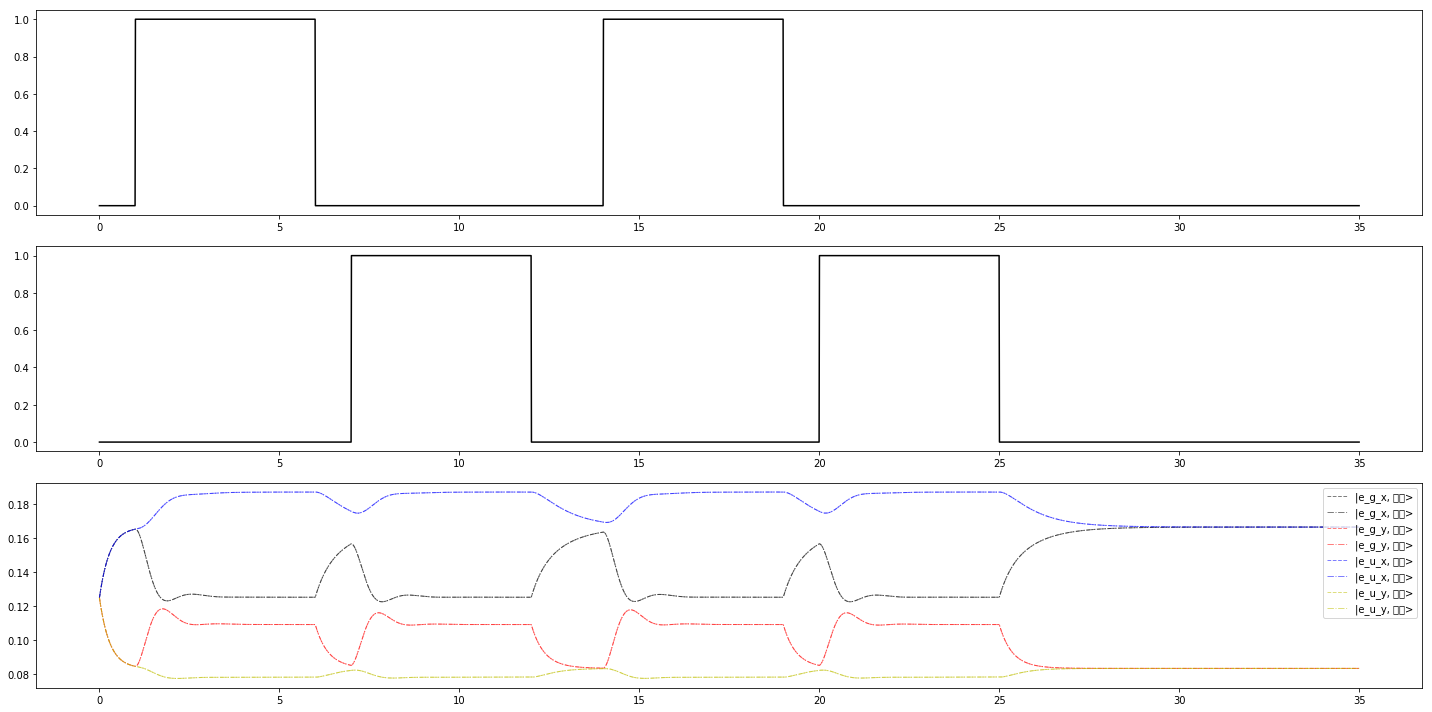

In [57]:
eigvals, eigsts = (HSys).eigenstates()

e_ops = []
for eigst in eigsts:
    e_ops.append(eigst*eigst.dag())

rho0 = eigsts[0]*eigsts[0].dag()
for eigval, eigst in zip(eigvals[1:], eigsts[1:]):
    rho0 += eigst*eigst.dag()*np.exp(-6.626e-34*(eigval-eigvals[0])/(kB*T))
rho0 = rho0/rho0.norm()

t = t_seq_L1
options = Options()
options.nsteps = 3000
output = mesolve(H, rho0, t, c_ops=c_ops, e_ops=e_ops, options=options, args=None)

labels = [
    '|e_g_x, 🠕>',
    '|e_g_x, 🠗>',
    '|e_g_y, 🠕>',
    '|e_g_y, 🠗>',
    '|e_u_x, 🠕>',
    '|e_u_x, 🠗>',
    '|e_u_y, 🠕>',
    '|e_u_y, 🠗>']
colors = [
    'k',
    'k',
    'r',
    'r',
    'b',
    'b',
    'y',
    'y'
]
styles = [
    '--',
    '-.',
    '--',
    '-.',
    '--',
    '-.',
    '--',
    '-.',
]
fig, axs = plt.subplots(3,1, figsize=(20,10))
fig.figsize = (20,10)
axs[0].plot(t, [pulse_seq_L1(t_) for t_ in t], '-k')

if Omega_L2:
    axs[1].plot(t, [pulse_seq_L2(t_) for t_ in t], '-k')

for i, exp in enumerate(output.expect):
    axs[2].plot(t, exp, label=labels[i], color=colors[i], linestyle=styles[i], alpha=0.5, linewidth=1)
axs[2].legend()

plt.tight_layout()
plt.show()

In [9]:
#Magnetic field unit vector
e_B_ext = np.array([[1],[1],[0]])
e_B_ext = e_B_ext/np.linalg.norm(e_B_ext)
Bs = np.linspace(0,7,100)

energies = np.zeros((N, len(Bs)))
for i, B in enumerate(Bs):

    #Zeeman coupling with quenching factor of f=0.1
    f = 0.1
    gamma_S = 2*mu_B/h
    gamma_L = mu_B/h
    
    B_ext = e_B_ext*B
    
    #Rotate into SiV internal coordinate system defined by applying (R_y*R_z)^-1
    B_x = np.squeeze(R_int_ext @ B_ext)[0]
    B_y = np.squeeze(R_int_ext @ B_ext)[1]
    B_z = np.squeeze(R_int_ext @ B_ext)[2]
        
    HZL = f*gamma_L*B_z*tensor((L_z_g+L_z_e),qeye(N_spins))    
    HZS = gamma_S*tensor(qeye(N_orbs),(B_x*S_x+B_y*S_y+B_z*S_z))
        
    energies[:,i] = (HOrb+HSO+HZL+HZS+HJT+HStr).eigenenergies()

In [ ]:


fig, axs = plt.subplots(3,1,True)
for i, energy in enumerate(energies):
    if i<4:
        axs[1].plot(Bs, energy, linestyle=styles[i], label=labels[i], color=colors[i])
    else:
        axs[0].plot(Bs, energy-1.68*e/h, linestyle=styles[i], label=labels[i], color=colors[i])
    
axs[0].legend()
axs[1].legend()
plt.show()

In [ ]:
#Fluorescence spectrum
tlist = np.linspace(0, 0.5e-6, 5000)
corr = correlation_2op_1t(H, None, tlist, c_ops, tensor(e_u_y*e_u_x.dag(),qeye(N_spins)), tensor(e_u_x*e_u_y.dag(),qeye(N_spins)))
wlist1, spec1 = spectrum_correlation_fft(tlist, corr)

fig, ax = plt.subplots(1, 1)
ax.plot(wlist1 / (2 * np.pi), spec1, 'b', lw=1, label='eseries method')
plt.show()
